In [1]:
%pylab inline
plt.style.use('bmh')
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [12]:
str(['amt annuity', 'amt credit max overdue', 'amt credit sum',
           'amt credit sum debt', 'amt credit sum limit', 'amt credit sum overdue',
           'amt req source year', 'cnt credit prolong', 'credit active',
           'credit day overdue', 'credit delay30', 'credit delay60', 'credit delay more',
           'credit facility', 'credit sum type', 'credit type', 'def',
           'dtime credit', 'dtime credit enddate', 'dtime credit enddate fact',
           'dtime credit update', 'id', 'num source', 'text payment discipline']).upper().replace(' ', '_')

"['AMT_ANNUITY',_'AMT_CREDIT_MAX_OVERDUE',_'AMT_CREDIT_SUM',_'AMT_CREDIT_SUM_DEBT',_'AMT_CREDIT_SUM_LIMIT',_'AMT_CREDIT_SUM_OVERDUE',_'AMT_REQ_SOURCE_YEAR',_'CNT_CREDIT_PROLONG',_'CREDIT_ACTIVE',_'CREDIT_DAY_OVERDUE',_'CREDIT_DELAY30',_'CREDIT_DELAY60',_'CREDIT_DELAY_MORE',_'CREDIT_FACILITY',_'CREDIT_SUM_TYPE',_'CREDIT_TYPE',_'DEF',_'DTIME_CREDIT',_'DTIME_CREDIT_ENDDATE',_'DTIME_CREDIT_ENDDATE_FACT',_'DTIME_CREDIT_UPDATE',_'ID',_'NUM_SOURCE',_'TEXT_PAYMENT_DISCIPLINE']"

In [14]:
data.columns

Index(['amt annuity', 'amt credit max overdue', 'amt credit sum',
       'amt credit sum debt', 'amt credit sum limit', 'amt credit sum overdue',
       'amt req source day', 'amt req source hour', 'amt req source mon',
       'amt req source qrt', 'amt req source week', 'amt req source year',
       'cnt credit prolong', 'credit active', 'credit currency',
       'credit day overdue', 'credit delay30', 'credit delay5',
       'credit delay60', 'credit delay90', 'credit delay more',
       'credit facility', 'credit sum type', 'credit type', 'def',
       'dtime credit', 'dtime credit enddate', 'dtime credit enddate fact',
       'dtime credit update', 'id', 'num source', 'sk date decision',
       'text payment discipline'],
      dtype='object')

In [15]:
train_idxs = pd.read_csv('sample/train.csv', usecols=['ID'])['ID'].unique()
test_idxs = pd.read_csv('sample/test.csv', usecols=['ID'])['ID'].unique()
np.save('sample/train_idxs.npy', train_idxs)
np.save('sample/test_idxs.npy', test_idxs)

usecols = ['AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 
           'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 
           'AMT_REQ_SOURCE_YEAR', 'CNT_CREDIT_PROLONG', 'CREDIT_ACTIVE',
           'CREDIT_DAY_OVERDUE', 'CREDIT_DELAY30', 'CREDIT_DELAY60', 
           'CREDIT_DELAY_MORE', 'CREDIT_FACILITY', 'CREDIT_SUM_TYPE', 'CREDIT_TYPE', 
           'DTIME_CREDIT', 'DTIME_CREDIT_ENDDATE', 'DTIME_CREDIT_ENDDATE_FACT', 
           'DTIME_CREDIT_UPDATE', 'ID', 'NUM_SOURCE', 'TEXT_PAYMENT_DISCIPLINE']

data = pd.read_csv('sample/test.csv', usecols=usecols).append(
    pd.read_csv('sample/train.csv', usecols=usecols.append('DEF')))
data.reset_index(drop=True, inplace=True)

data['TEXT_PAYMENT_DISCIPLINE'] = (data['TEXT_PAYMENT_DISCIPLINE']
    [data['TEXT_PAYMENT_DISCIPLINE'].notnull()].apply(len))

In [18]:
%%time
first_key = ['ID', 'CREDIT_ACTIVE', 'DTIME_CREDIT',
    'DTIME_CREDIT_ENDDATE', 'DTIME_CREDIT_ENDDATE_FACT']

data = data[data['NUM_SOURCE'] == 1].groupby(first_key).median().merge(
    data[data['NUM_SOURCE'] == 2].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True).merge(
    data[data['NUM_SOURCE'] == 3].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True).merge(
    data[data['NUM_SOURCE'] == 4].groupby(first_key).median(),
    how='outer', left_index=True, right_index=True)

data.columns = data.columns.map(lambda x: x[:-2])
data = data.apply(lambda x: x.groupby(data.columns).median(), axis=1)
data.drop('NUM_SOURCE', axis=1, inplace=True)
data.to_csv('sample/data_merged.csv')

CPU times: user 17min 44s, sys: 6.72 s, total: 17min 51s
Wall time: 17min 50s


In [19]:
data = pd.read_csv('sample/data_merged.csv')
data.shape

(1483598, 31)

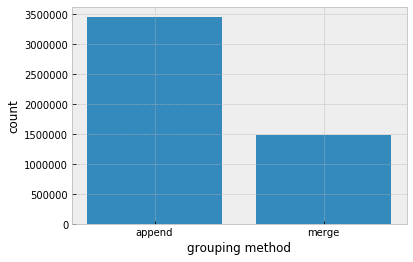

In [265]:
plt.bar(('merge', 'append'), (data.shape[0], raw_shape))
plt.xlabel('grouping method')
plt.ylabel('count')
plt.savefig('images/grouping.pdf')

In [190]:
train = data.reset_index().merge(pd.DataFrame([], index=train_idxs), left_on='id', right_index=True)
test = data.reset_index().merge(pd.DataFrame([], index=test_idxs), left_on='id', right_index=True)

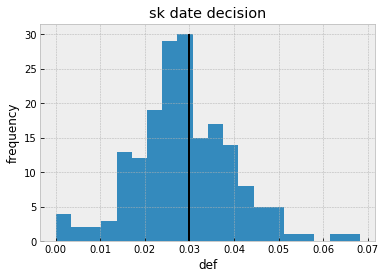

In [191]:
train.groupby('sk date decision')['def'].mean().plot.hist(bins=20)
plt.vlines(0.03, 0, 30)
plt.title('sk date decision')
plt.xlabel('def')
plt.ylabel('frequency')
plt.savefig('images/sk_date_decision.pdf')

In [196]:
train.groupby('sk date decision')[['id']].nunique().tail(5)

,id
sk date decision,
20160225.0,983
20160226.0,980
20160227.0,793
20160228.0,199
20160229.0,1075


In [199]:
test.groupby('sk date decision')[['id']].nunique().head(5)

,id
sk date decision,
20160301.0,999
20160302.0,892
20160303.0,917
20160304.0,896
20160305.0,630


In [134]:
test.groupby('sk date decision')['id'].nunique().index.sort_values()[:5]

Float64Index([20160301.0, 20160302.0, 20160303.0, 20160304.0, 20160305.0], dtype='float64', name='sk date decision')

In [135]:
train.drop('sk date decision', axis=1, inplace=True)
test.drop('sk date decision', axis=1, inplace=True)

In [143]:
from sklearn.metrics import roc_auc_score
defs = train.groupby('id')['def'].max()

In [144]:
pay = train[['id','text payment discipline']].copy()
pay.fillna(pay['text payment discipline'].mean(), inplace=True)

In [145]:
pay_mean = pay.groupby('id').mean()
roc_auc_score(defs, -pay_mean)

0.56805002626057577

In [146]:
pay_std = pay.groupby('id').std().fillna(0)
roc_auc_score(defs, -pay_std)

0.54504352792107991

In [224]:
values

array([ 0.56805003,  0.54504353])

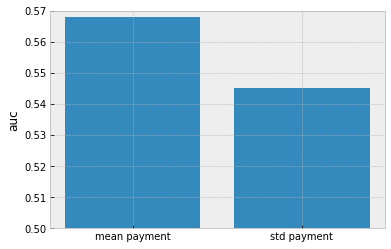

In [248]:
values = np.abs(np.array((roc_auc_score(defs, -pay_mean), roc_auc_score(defs, -pay_std))))
plt.ylabel('auc')
plt.ylim(0.5, 0.57)
plt.bar(('mean payment', 'std payment'), values)
plt.savefig('images/meanstd_auc.pdf')

In [251]:
names = ['hour', 'day', 'week', 'mon', 'qrt', 'year']

In [252]:
rocs = [roc_auc_score(defs, -(train.groupby('id') \
    ['amt req source {}'.format(name)].sum() > 0).astype(int)) for name in names]
rocs = np.abs(np.array(rocs))

In [254]:
rocs

array([ 0.49952037,  0.50034122,  0.49946294,  0.49676301,  0.50137613,
        0.51051476])

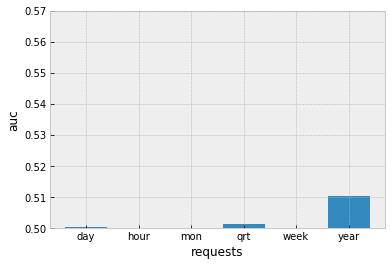

In [255]:
plt.bar(names, rocs)
plt.ylabel('auc')
plt.ylim(0.5, 0.57)
plt.xlabel('requests')
plt.savefig('images/requests.pdf')

In [256]:
train['credit currency'] = train['credit currency'].apply(lambda x: 0 if x==0 else 1)
train['def'] = train['def'].apply(lambda x: int(x))
train.pivot_table('id', 'credit currency', 'def', 'count')

def,0,1
credit currency,,
0,748510,22998
1,979,30


In [257]:
roc_auc_score(defs, -train.groupby('id')['credit currency'].sum())

0.50016769706527386

In [258]:
rocs = list()
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay5'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay30'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay60'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id')['credit delay90'].sum()))
rocs.append(roc_auc_score(defs, train.groupby('id') \
    [['credit delay30', 'credit delay60']].sum().sum(axis=1)))
rocs = np.abs(np.array(rocs))

In [259]:
names = ('5', '30', '60', '90', '30+60')

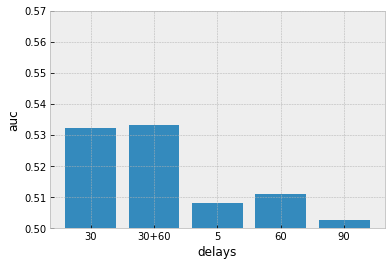

In [260]:
plt.bar(names, rocs)
plt.ylabel('auc')
plt.ylim(0.5, 0.57)
plt.xlabel('delays')
plt.savefig('images/delays.pdf')